## Recommendations for Microsoft's New Movie Studio

####  In this notebook we are going to analyze the relationship between the movie success and movie time of release,movie runtime, movie genre, directors, and actors/actresses. Success will be based on ROI and Profit margin.

#### First objective is to clean up the movie budget dataframe, then merge all the relevant data sets.

In [1]:

#importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import figure
import sqlite3

In [2]:
ls

 Volume in drive C is Local Disk
 Volume Serial Number is EAC5-AF97

 Directory of C:\Users\stefano caruso\OneDrive\Desktop\flatiron\Movie-Studio-Project\notebook_development

10/06/2022  12:50 PM           345,850 #1 jbook stefano.ipynb
10/06/2022  12:50 PM    <DIR>          .
10/06/2022  12:50 PM    <DIR>          ..
10/06/2022  08:36 AM    <DIR>          .ipynb_checkpoints
10/06/2022  08:32 AM           259,503 Andrew_Jbook_10_04_22.ipynb
10/06/2022  12:04 PM           556,270 jbook_Samuel.ipynb
               3 File(s)      1,161,623 bytes
               3 Dir(s)  166,778,290,176 bytes free


In [3]:
#creating connection to the data
conn = sqlite3.connect('../zippedData/im.db/im.db')

In [4]:
#creating variable to read csv file
funds = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')

In [5]:
#examining structure of database and viewing all tables 
pd.read_sql("""

SELECT *

FROM sqlite_master

""", conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [6]:
#creating finance calculations and formating numbers
numbers = funds.copy()



#funtion for cleaning
def clean_a_money_column(df, series_title):
    df[series_title] = df[series_title].str.replace('$','')
    df[series_title] = df[series_title].str.replace(',','')
    df[series_title] = pd.to_numeric(df[series_title])
    return df



#remove $ string
numbers = clean_a_money_column(numbers,'worldwide_gross')
numbers = clean_a_money_column(numbers,'domestic_gross')
numbers = clean_a_money_column(numbers,'production_budget')



# new column foreign_gross, Profit Margin, ROI
numbers['net_income'] = numbers['worldwide_gross'] - numbers['production_budget']
numbers['foreign_gross'] = numbers['worldwide_gross'] - numbers['domestic_gross']
numbers['Profit Margin'] = (numbers['net_income']*100)/numbers['worldwide_gross']
numbers.loc[numbers['Profit Margin'] == float('-inf'), 'Profit Margin'] = 0
numbers['ROI'] = (numbers['net_income']) / numbers['production_budget'] * 100


# new columns month and year 
numbers['Year'] = pd.to_numeric(numbers['release_date'].map(lambda x: x[-4:]))
numbers['Month'] = numbers['release_date'].map(lambda x: x[:3])



#check for dupes
movie_dupes = pd.Series(numbers['movie'].value_counts())
title_dupes = [movie_dupes.index[index] for index in list(range(len(movie_dupes))) if movie_dupes.values[index] > 1]
numbers[numbers['movie'].isin(title_dupes)]

numbers


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_income,foreign_gross,Profit Margin,ROI,Year,Month
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,2015837654,84.692106,553.257713,2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,804600000,60.733080,154.667286,2011,May
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,107000000,-133.703598,-57.210757,2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,944008095,76.436443,324.384139,2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,696540365,75.925058,315.369636,2017,Dec
...,...,...,...,...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,-7000,0,0.000000,-100.000000,2018,Dec
5778,79,"Apr 2, 1999",Following,6000,48482,240495,234495,192013,97.505146,3908.250000,1999,Apr
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,-3662,0,-273.692078,-73.240000,2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,0,0.000000,-100.000000,2015,Sep


# Reading in IMDB's title.basics dataset

In [7]:
#creating variable for movie basics table query, convertig sql into pandas df
genetime = pd.read_sql("""

SELECT primary_title as movie, start_year as year, runtime_minutes, genres
FROM

movie_basics

""", conn)

genetime

,movie,year,runtime_minutes,genres
0,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,The Other Side of the Wind,2018,122.0,Drama
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...
146139,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,Dankyavar Danka,2013,NaN,Comedy
146142,6 Gunn,2017,116.0,None


In [181]:
#creating a variable for merging the im.bd query with the movie budgets data set
combined_df = numbers.merge(genetime)


In [182]:
#checking for missing data
combined_df.isna().sum()

id                     0
release_date           0
movie                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
net_income             0
foreign_gross          0
Profit Margin          0
ROI                    0
Year                   0
Month                  0
year                   0
runtime_minutes      487
genres                72
dtype: int64

In [183]:
# creating a new variable after dropping missing data
clean_df = combined_df.dropna(subset=['runtime_minutes', 'genres'])
clean_df.isna().sum()


id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
net_income           0
foreign_gross        0
Profit Margin        0
ROI                  0
Year                 0
Month                0
year                 0
runtime_minutes      0
genres               0
dtype: int64

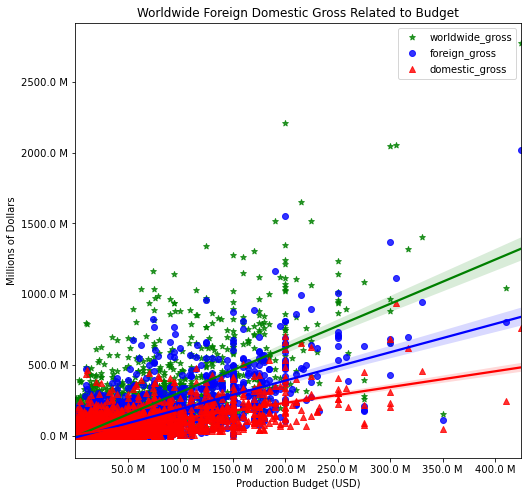

In [184]:
#chart to examine the difference between foreign and domestic gross
'Worldwide & Domestic Gross Related to Production Budget',
# set up figure convert to millions
def million_formatter(x, pos):
    return "%.1f M" % (x/1E6)
fig, ax = plt.subplots(figsize=(8,8), sharey=True)
# green dots/line will be ww gross as a function of production_budget
ax1 = sns.regplot(data=numbers, x='production_budget',
                 y='worldwide_gross', color='green',marker='*', label='worldwide_gross')
# blue dots/line will be foreign_gross gross as a function of production_budget
ax2 = sns.regplot(data=numbers, x='production_budget',
                 y='foreign_gross', color='blue',marker='o', label='foreign_gross')
# red dots/line will be domestic_gross as a function of production_budget
ax2 = sns.regplot(data=numbers, x='production_budget',
                 y='domestic_gross', color='red',marker='^', label='domestic_gross')
# include a legend
ax.legend()
# set title and axis labels
ax.set(title='Worldwide Foreign Domestic Gross Related to Budget',
      xlabel='Production Budget (USD)',
      ylabel = 'Millions of Dollars')
ax.xaxis.set_major_formatter(million_formatter)
ax.yaxis.set_major_formatter(million_formatter)

In [185]:
#created a list to establish the single genres
gs = []
genlist = clean_df['genres'].str.split(',')

for things in genlist:
    gs.extend(things)
ugs = set(gs)
ugs

list(ugs)

['Documentary',
 'Sport',
 'Fantasy',
 'History',
 'Biography',
 'Music',
 'War',
 'Crime',
 'Thriller',
 'Animation',
 'Horror',
 'Drama',
 'Comedy',
 'Sci-Fi',
 'Adventure',
 'Romance',
 'Family',
 'News',
 'Western',
 'Mystery',
 'Musical',
 'Action',
 'Reality-TV']

### creating scatter plot to analyze runtime vs WWgross for each genre

In [190]:
def generun(gene):
    genre_fun = clean_df.loc[clean_df['genres'].str.contains(gene)]
    fig, ax = plt.subplots(figsize=(10,10))
    x = genre_fun['runtime_minutes']
    y = genre_fun['worldwide_gross']
    plt.ticklabel_format(style='plain')
    ax.scatter(x,y)
    ax.axvline(x.mean(), label='Mean', linestyle='--', color= 'Red')
    ax.set_xlabel('runtime in minutes')
    ax.set_ylabel('worldwide_gross')
    ax.set_title(print(f'Runtime vs. WorldWide Gross for {gene}'));

In [191]:
# copied over clean_df 
runtime_rec = clean_df

## Adventure runtime Medians  
##### creating below and above median from runtime orignal median for the top 5 genres

In [192]:
genre_Ad = runtime_rec.loc[runtime_rec['genres'].str.contains('Adventure')]


In [193]:
genre_Ad_median = genre_Ad['runtime_minutes'].median()

genre_Ad_median

104.0

In [194]:
final_Ad_H = runtime_rec.loc[runtime_rec['runtime_minutes'] > genre_Ad_median]



In [195]:
H_Ad_med_gross = final_Ad_H['worldwide_gross'].median()
H_Ad_med_gross



50783138.0

In [196]:
final_Ad_L = runtime_rec.loc[runtime_rec['runtime_minutes'] < genre_Ad_median]


In [197]:
# Adventure below runtime median
L_Ad_med_gross = final_Ad_L['worldwide_gross'].median()
L_Ad_med_gross

17023121.0

# Action runtime Medians 

In [198]:
genre_Action = runtime_rec.loc[runtime_rec['genres'].str.contains('Action')]


In [199]:
genre_Action_median = genre_Action['runtime_minutes'].median()

genre_Action_median

107.0

In [200]:
final_Action_H = runtime_rec.loc[runtime_rec['runtime_minutes'] > genre_Action_median]

In [201]:
H_Action_med_gross = final_Ad_H['worldwide_gross'].median()
H_Action_med_gross


50783138.0

In [202]:
final_Action_L = runtime_rec.loc[runtime_rec['runtime_minutes'] < genre_Action_median]

In [203]:
# action below runtime median
L_Action_med_gross = final_Action_L['worldwide_gross'].median()
L_Action_med_gross

17856688.0

# Sci_Fi runtime Medians

In [204]:
genre_Sci_fi = runtime_rec.loc[runtime_rec['genres'].str.contains('Sci-Fi')]

In [205]:
genre_Sci_fi_median = genre_Sci_fi['runtime_minutes'].median()

genre_Sci_fi_median

106.0

In [206]:
final_Sci_fi_H = runtime_rec.loc[runtime_rec['runtime_minutes'] > genre_Sci_fi_median]

In [207]:
H_Sci_fi_med_gross = final_Sci_fi_H['worldwide_gross'].median()
H_Sci_fi_med_gross

54462971.0

In [208]:
final_Sci_fi_L = runtime_rec.loc[runtime_rec['runtime_minutes'] < genre_Sci_fi_median]

In [209]:
# Sci fi below runtime median
L_Sci_fi_med_gross = final_Sci_fi_L['worldwide_gross'].median()
L_Sci_fi_med_gross

17549645.0

# Animaiton runtime medians

In [210]:
genre_ann = runtime_rec.loc[runtime_rec['genres'].str.contains('Animation')]

In [211]:
genre_ann_median = genre_ann['runtime_minutes'].median()

genre_ann_median

93.0

In [212]:
final_ann_H = runtime_rec.loc[runtime_rec['runtime_minutes'] > genre_ann_median]

In [213]:
H_ann_med_gross = final_ann_H['worldwide_gross'].median()
L_ann_med_gross

15471969.0

In [214]:
final_ann_L = runtime_rec.loc[runtime_rec['runtime_minutes'] < genre_ann_median]

In [215]:
# animation below runtime median
L_ann_med_gross = final_ann_L['worldwide_gross'].median()
L_ann_med_gross

15471969.0

# Fantasy runtime medians

In [216]:
genre_fan = runtime_rec.loc[runtime_rec['genres'].str.contains('Fantasy')]

In [217]:
genre_fan_median = genre_fan['runtime_minutes'].median()

genre_fan_median

107.0

In [218]:
final_fan_H = runtime_rec.loc[runtime_rec['runtime_minutes'] > genre_fan_median]

In [219]:
H_fan_med_gross = final_fan_H['worldwide_gross'].median()
H_fan_med_gross

54539920.0

In [220]:
final_fan_L = runtime_rec.loc[runtime_rec['runtime_minutes'] < genre_fan_median]

In [221]:
# fantasy below runtime median
L_fan_med_gross = final_fan_L['worldwide_gross'].median()
L_fan_med_gross

17856688.0

In [222]:
# # List for above runtime median
top_5_Above_rt = [H_fan_med_gross, H_ann_med_gross, H_Sci_fi_med_gross, H_Action_med_gross, H_Ad_med_gross]

In [223]:
# List for below runtime median
top_5_below_rt = [L_fan_med_gross, L_ann_med_gross, L_Sci_fi_med_gross, L_Action_med_gross, L_Ad_med_gross]

# Visual for runtime median recommendation

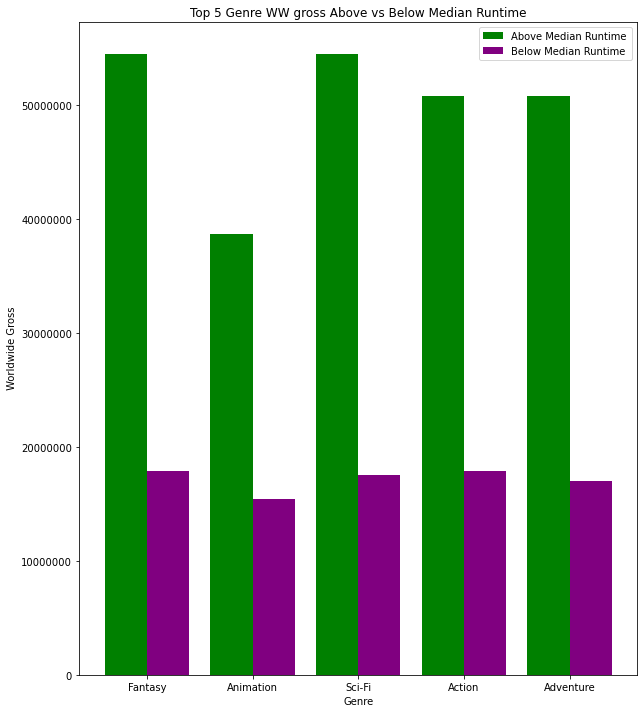

In [293]:




x_ticks_labels = ['Fantasy', 'Animation', 'Sci-Fi', 'Action', 'Adventure']

x = x_ticks_labels



X_axis = np.arange(len(x))

plt.figure(figsize=(10,12))




plt.bar(X_axis - .2, top_5_Above_rt, color ='green',
        width = 0.4, label = 'Above Median Runtime' )
plt.bar(X_axis + .2, top_5_below_rt, color ='purple',
        width = 0.4, label = 'Below Median Runtime ' )
plt.xlabel("Genre")
plt.ylabel(" Worldwide Gross")
plt.title("Top 5 Genre WW gross Above vs Below Median Runtime")
plt.xticks(X_axis, x_ticks_labels)
plt.legend()
plt.ticklabel_format(style='plain', axis='y')
plt.show();






# Genre Data Exploration 

Runtime vs. WorldWide Gross for Adventure


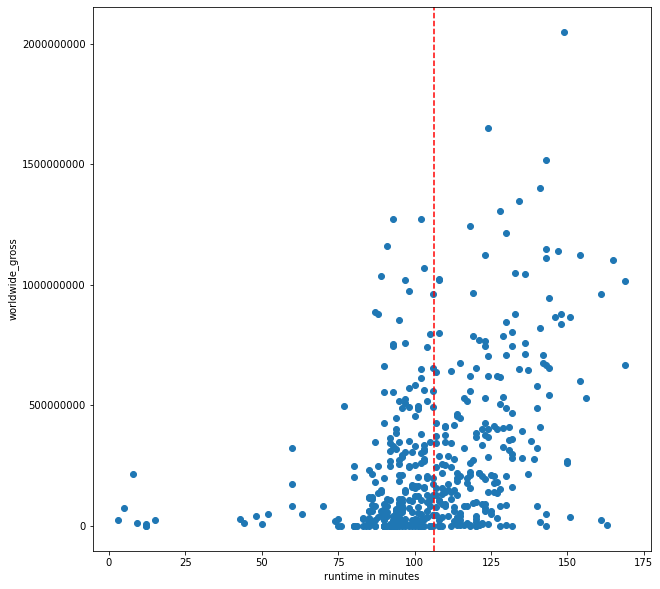

In [225]:
generun('Adventure')

Runtime vs. WorldWide Gross for Animation


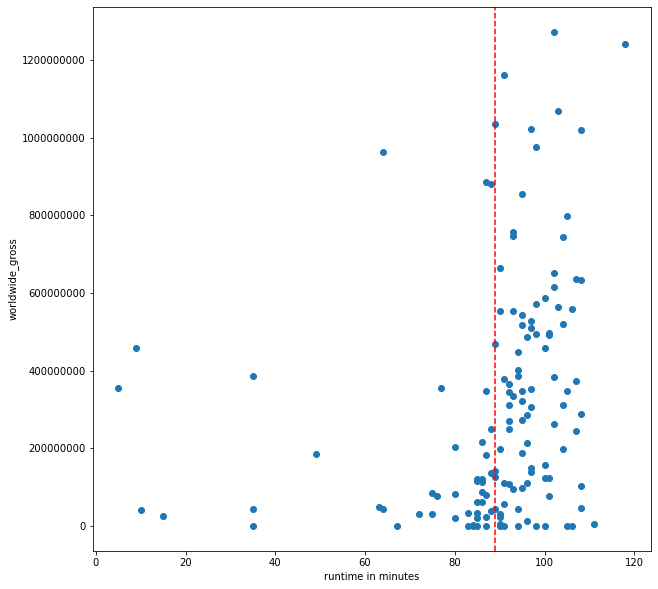

In [226]:
generun('Animation')

Runtime vs. WorldWide Gross for Fantasy


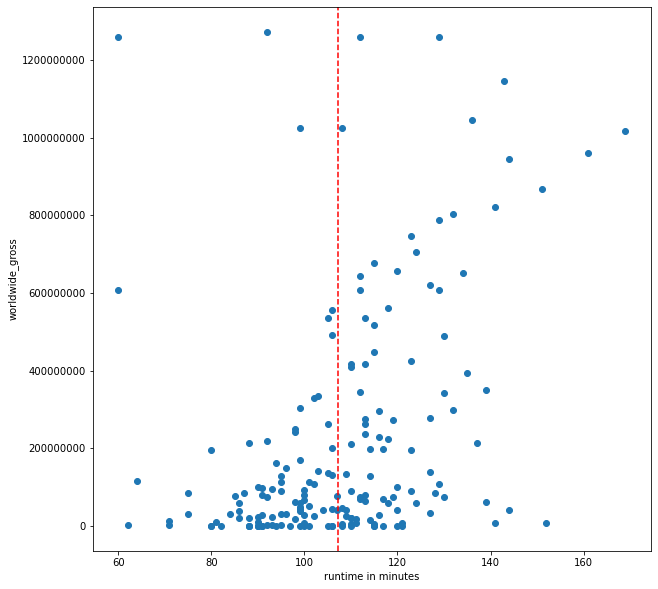

In [227]:
generun('Fantasy')

Runtime vs. WorldWide Gross for Action


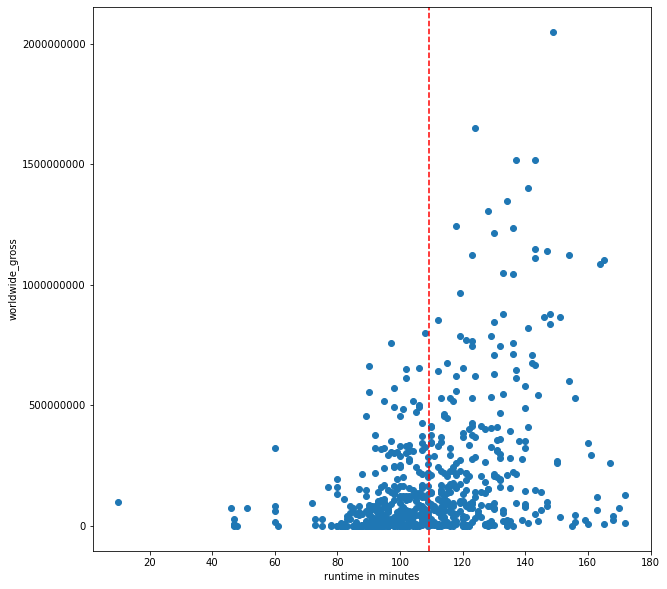

In [228]:
generun('Action')


Runtime vs. WorldWide Gross for Sci-Fi


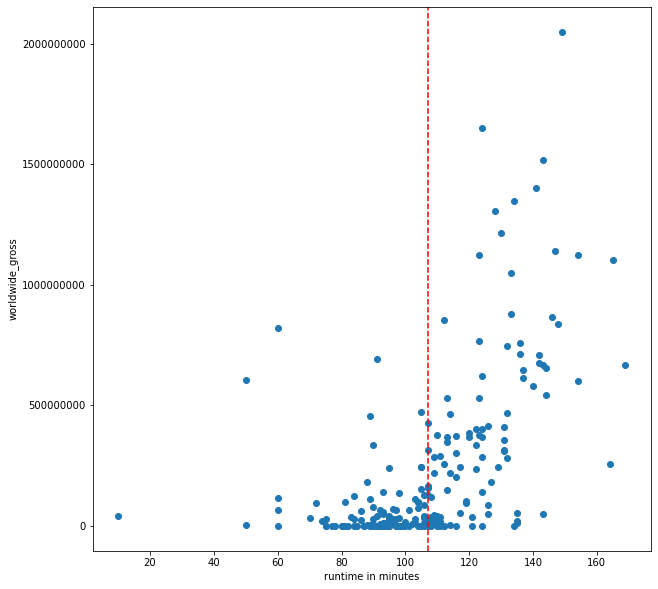

In [229]:
generun('Sci-Fi')

### Setting variable to sort by ROI for the graph

In [230]:
roi_df = clean_df.sort_values(by='ROI', ascending=False)[50:]

In [231]:
roi_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_income,foreign_gross,Profit Margin,ROI,Year,Month,year,runtime_minutes,genres
2813,51,"Oct 21, 2011",Paranormal Activity 3,5000000,104028807,207039844,202039844,103011037,97.585006,4040.796880,2011,Oct,2011,83.0,"Horror,Mystery,Thriller"
2715,84,"Oct 3, 2014",Annabelle,6500000,84273813,256862920,250362920,172589107,97.469467,3851.737231,2014,Oct,2014,99.0,"Horror,Mystery,Thriller"
3346,15,"Aug 27, 2010",The Last Exorcism,1800000,41034350,70165900,68365900,29131550,97.434651,3798.105556,2010,Aug,2010,87.0,"Drama,Horror,Thriller"
955,68,"Feb 9, 1940",Pinocchio,2289247,84300000,84300000,82010753,0,97.284405,3582.433569,1940,Feb,2015,75.0,Documentary
953,68,"Feb 9, 1940",Pinocchio,2289247,84300000,84300000,82010753,0,97.284405,3582.433569,1940,Feb,2012,75.0,"Animation,Family,Fantasy"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,56,"Jun 5, 2009",Home,12000000,0,0,-12000000,0,0.000000,-100.000000,2009,Jun,2015,4.0,Drama
248,56,"Jun 5, 2009",Home,12000000,0,0,-12000000,0,0.000000,-100.000000,2009,Jun,2015,58.0,Documentary
249,56,"Jun 5, 2009",Home,12000000,0,0,-12000000,0,0.000000,-100.000000,2009,Jun,2017,35.0,"Documentary,Family"
250,56,"Jun 5, 2009",Home,12000000,0,0,-12000000,0,0.000000,-100.000000,2009,Jun,2016,35.0,"Animation,Documentary"


### DOING GRAPHS OF BUDGET TO ROI BY GENRE

In [232]:
#
def genebudget(gene):
    top_sort = roi_df.sort_values(by=['ROI'], ascending=False)[1:]
    clean_df = top_sort.loc[top_sort['genres'].str.contains(gene)]
    fig, ax = plt.subplots(figsize=(10,10))
    y = clean_df['ROI']
    x = clean_df['production_budget']
    ax.scatter(x,y)
    plt.ticklabel_format(style='plain')
    ax.set_yticks([100, 500, 1000, 2000, 3000])
    ax.set_xticks([10000000, 70000000, 150000000, 250000000])
    ax.axvline(x.median(), label='Median', linestyle='--', color= 'Red')
    ax.set_ylabel('ROI by percentage')
    ax.set_xlabel('production budget 10MM - 250MM')
    ax.set_title(print(f'budget - ROI comaprison for {gene}'))
    

budget - ROI comaprison for Adventure


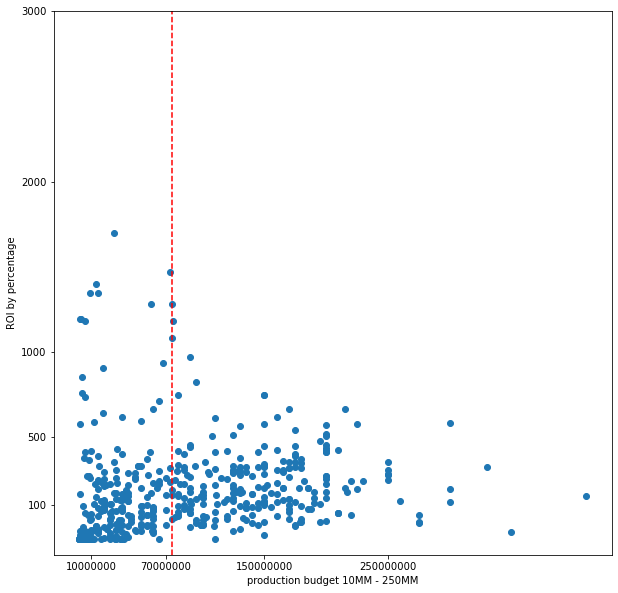

In [233]:
genebudget('Adventure')

budget - ROI comaprison for Animation


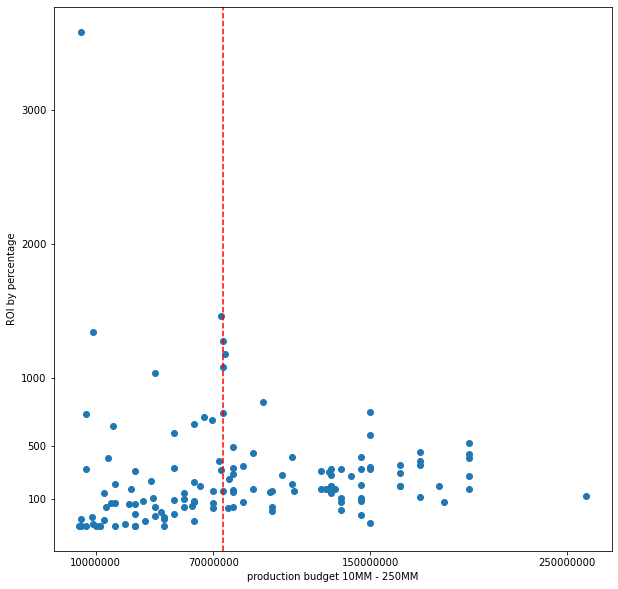

In [234]:
genebudget('Animation')

budget - ROI comaprison for Fantasy


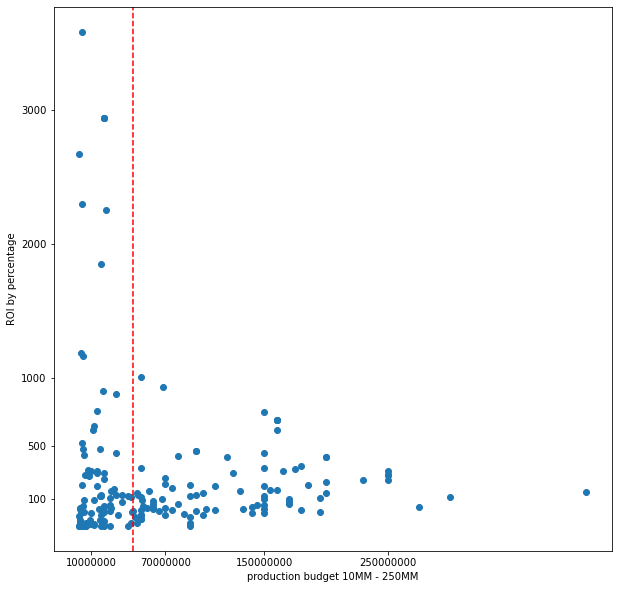

In [235]:
genebudget('Fantasy')

budget - ROI comaprison for Action


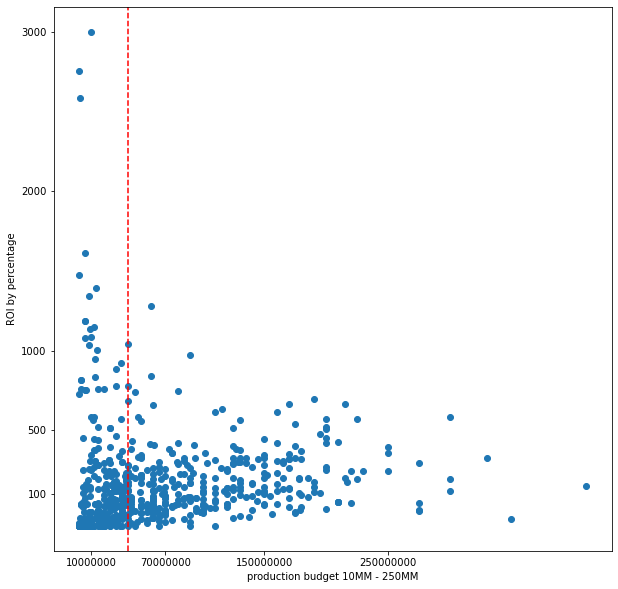

In [236]:

genebudget('Action')

budget - ROI comaprison for Sci-Fi


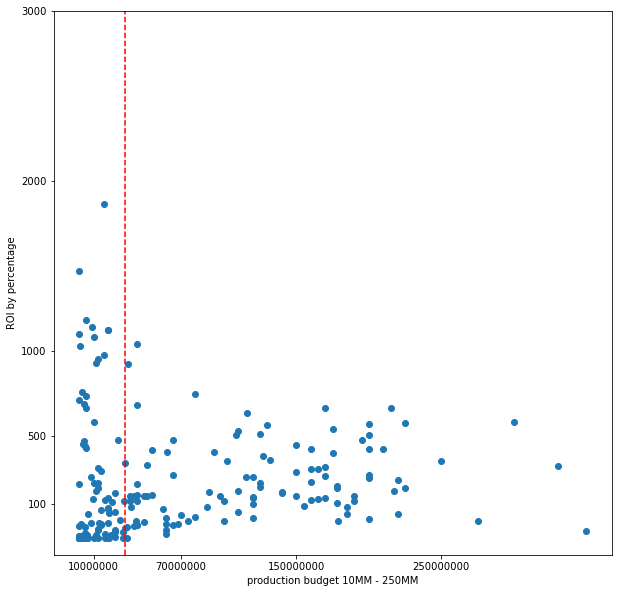

In [237]:
genebudget('Sci-Fi')

In [238]:
clean_df.loc[huey['ROI'] > 20000]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_income,foreign_gross,Profit Margin,ROI,Year,Month,year,runtime_minutes,genres
2047,37,"Oct 17, 1978",Halloween,325000,47000000,70000000,69675000,23000000,99.535714,21438.461538,1978,Oct,2018,106.0,"Horror,Thriller"
2965,77,"Oct 1, 1968",Night of the Living Dead,114000,12087064,30087064,29973064,18000000,99.621100,26292.161404,1968,Oct,2014,79.0,Horror
3452,11,"Nov 21, 1976",Rocky,1000000,117235147,225000000,224000000,107764853,99.555556,22400.000000,1976,Nov,2013,136.0,"Action,Comedy,Drama"
3535,47,"Aug 13, 1942",Bambi,858000,102797000,268000000,267142000,165203000,99.679851,31135.431235,1942,Aug,2013,58.0,"Biography,Documentary"
3751,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,41556474,18892064,99.759941,41556.474000,2015,Jul,2015,81.0,"Horror,Mystery,Thriller"


budget - ROI comaprison for Romance


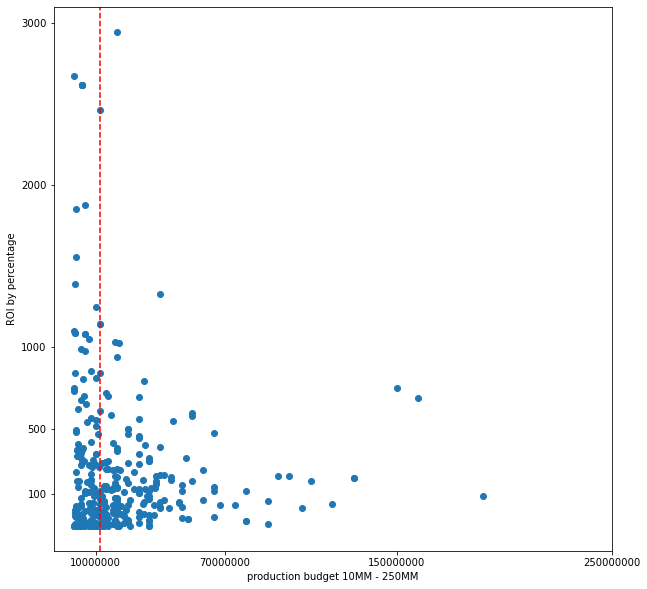

In [239]:
genebudget('Romance')

In [240]:
#individual code for merging tables, expliding for individual genres

In [241]:
run_time = pd.read_sql("""
select *
from movie_basics
""", conn)

In [242]:
run_time['genres_list'] = run_time['genres'].str.split(',')

In [243]:
single_genres = run_time.explode('genres_list')

In [244]:
num_genre_join = numbers.merge(single_genres, left_on='movie', right_on='primary_title')

In [245]:
#createing a variable to get the mean of the world wide gross for each genre
num_genre_group_mean_WWG = num_genre_join.groupby('genres_list')['worldwide_gross'].median()

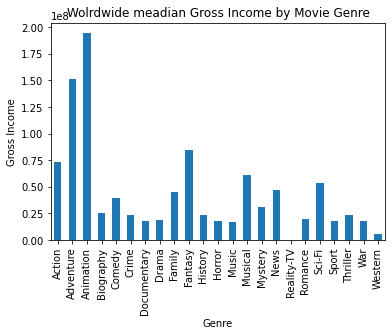

In [246]:
#table to demonstrate the top genres by wwgross median
num_genre_group_mean_WWG.plot(kind='bar', title ='Wolrdwide meadian Gross Income by Movie Genre', ylabel='Gross Income', xlabel='Genre');

In [247]:
#sorting values of mean worldwide gross grouped by genre
num_genre_group_mean_WWG.sort_values(ascending=False).head(6)

genres_list
Animation    194503502.0
Adventure    150977672.0
Fantasy       84227013.0
Action        73249137.5
Musical       61031932.0
Sci-Fi        53424681.0
Name: worldwide_gross, dtype: float64

In [248]:
#createing a variable to get the mean of the world wide gross for each genre
num_genre_production = num_genre_join.groupby('genres_list')['production_budget'].median()
sort_production = num_genre_production.sort_values(ascending=False)

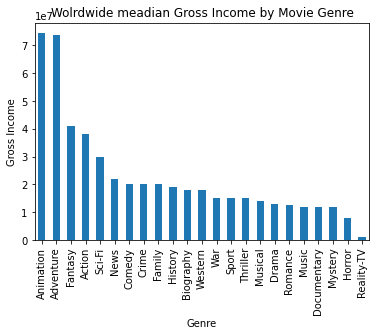

In [249]:
#table to demonstrate the top genres by wwgross median
sort_production.plot(kind='bar', title ='Wolrdwide meadian Gross Income by Movie Genre', ylabel='Gross Income', xlabel='Genre');


In [250]:
# Market selection on Genres

In [256]:
gen_list_med = num_genre_join.groupby('genres_list').median()

In [257]:
gen_list_med_foreign = gen_list_med['foreign_gross']
gen_list_med_foreign

genres_list
Action          34657447.0
Adventure       85523894.0
Animation      104810579.0
Biography        8241985.0
Comedy          13083952.0
Crime            8017344.5
Documentary      3795236.0
Drama            4796664.0
Family          12522149.5
Fantasy         42367409.5
History         11705292.0
Horror           5793429.0
Music            2769933.0
Musical         22513319.0
Mystery         11353097.0
News            40000000.0
Reality-TV             0.0
Romance          5547931.0
Sci-Fi          21503654.0
Sport            1357632.0
Thriller         7551757.0
War              4357174.0
Western          1616726.0
Name: foreign_gross, dtype: float64

In [266]:
# created a variable to calculate te domestic gross medians listed by genre
gen_list_med_domestic = gen_list_med['domestic_gross']
gen_list_med_domestic

genres_list
Action         32754514.0
Adventure      58243820.5
Animation      83295507.0
Biography      14221212.5
Comedy         23388906.0
Crime          13216983.5
Documentary     7316658.0
Drama           9427026.0
Family         29238981.5
Fantasy        37381278.5
History         9161542.5
Horror         11107431.0
Music          11862398.0
Musical        38322743.0
Mystery        15821461.0
News           15716828.0
Reality-TV            0.0
Romance        11998985.0
Sci-Fi         27447471.0
Sport          11242801.0
Thriller       14015307.0
War             4200117.0
Western         1686429.0
Name: domestic_gross, dtype: float64

In [267]:
#created a list variable for the top five foreign gross medians
top_5_dmeds = [gen_list_med_foreign['Action'], gen_list_med_foreign['Adventure'], gen_list_med_foreign['Fantasy'], gen_list_med_foreign['Sci-Fi'], gen_list_med_foreign['Animation']]

In [269]:
gen_list_med_foreign

genres_list
Action          34657447.0
Adventure       85523894.0
Animation      104810579.0
Biography        8241985.0
Comedy          13083952.0
Crime            8017344.5
Documentary      3795236.0
Drama            4796664.0
Family          12522149.5
Fantasy         42367409.5
History         11705292.0
Horror           5793429.0
Music            2769933.0
Musical         22513319.0
Mystery         11353097.0
News            40000000.0
Reality-TV             0.0
Romance          5547931.0
Sci-Fi          21503654.0
Sport            1357632.0
Thriller         7551757.0
War              4357174.0
Western          1616726.0
Name: foreign_gross, dtype: float64

In [283]:
#created a list variable for the top five foreign gross medians
top_5_domestic_meds = [gen_list_med_domestic['Action'], gen_list_med_domestic['Adventure'], gen_list_med_domestic['Fantasy'], gen_list_med_domestic['Sci-Fi'], gen_list_med_domestic['Animation']]

In [288]:
top_5_domestic_meds

[32754514.0, 58243820.5, 37381278.5, 27447471.0, 83295507.0]

In [284]:
#created varibable for top 5 foreign medians in the same order as domestic
top_5_foreign_meds = [gen_list_med_foreign['Action'], gen_list_med_foreign['Adventure'], gen_list_med_foreign['Fantasy'], gen_list_med_foreign['Sci-Fi'], gen_list_med_foreign['Animation']]

In [285]:
#created a variable to align the top five foriegn gross medians for our char. We also put the in the same order as the list of top 5 domestic
top_5_foreign_meds

[34657447.0, 85523894.0, 42367409.5, 21503654.0, 104810579.0]

In [291]:
#created a variable to get the median forigen gross for each genre
#jupe_for = num_genre_join.groupby('genres_list')['foreign_gross'].median()
#jupe_for

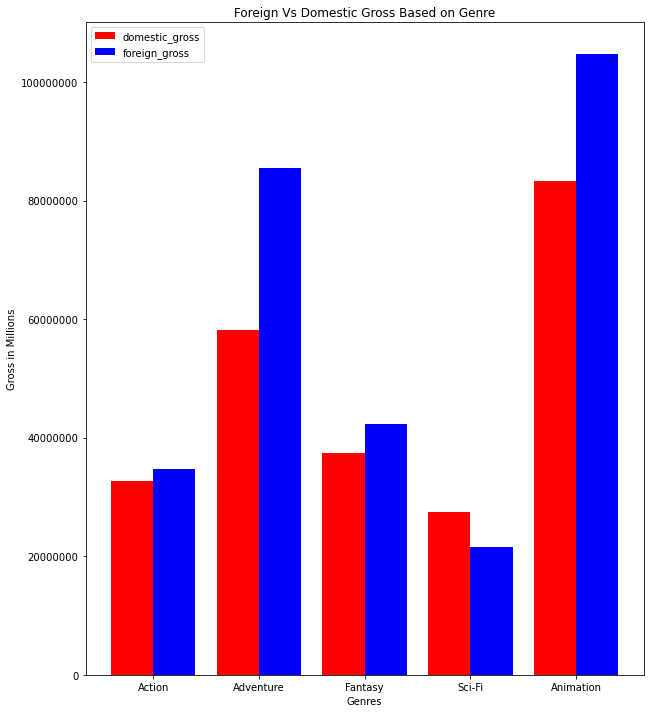

In [292]:
#created a bar chart that shows the difference  between each genres foreign and domestic gross
x = ['Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Animation']
x_axis = np.arange(len(x))
plt.figure(figsize=(10,12))
plt.bar(x_axis - .2, top_5_domestic_meds, color ='red',
        width = 0.4, label = 'domestic_gross' )
plt.bar(x_axis + .2, top_5_foreign_meds, color ='blue',
        width = 0.4, label = 'foreign_gross' )
plt.xlabel("Genres")
plt.ylabel("Gross in Millions")
plt.title("Foreign Vs Domestic Gross Based on Genre")
plt.xticks(x_axis,x)
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show();